<a href="https://colab.research.google.com/github/sacthewitch/MI4002/blob/main/MI4002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)

# Visual Baseline

In [4]:
vis_data_dir = '/content/drive/MyDrive/Loose Gravel Condition/visual'
TRAIN_VIS = 'train'
VAL_VIS = 'valid'
TEST_VIS = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN_VIS: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL_VIS: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST_VIS: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(vis_data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN_VIS, VAL_VIS, TEST_VIS]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN_VIS, VAL_VIS, TEST_VIS]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN_VIS, VAL_VIS, TEST_VIS]}

for x in [TRAIN_VIS, VAL_VIS, TEST_VIS]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
vis_class_names = image_datasets[TRAIN_VIS].classes
print(image_datasets[TRAIN_VIS].classes)

Loaded 367 images under train
Loaded 105 images under valid
Loaded 54 images under test
Classes: 
['Class_1', 'Class_2', 'Class_3', 'Class_4']


In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[vis_class_names[x] for x in classes])



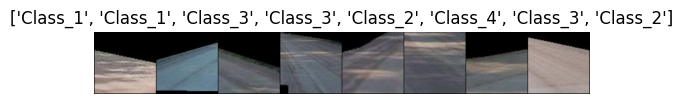

In [6]:
# Get a batch of training data
vis_inputs, vis_classes = next(iter(dataloaders[TRAIN_VIS]))
show_databatch(vis_inputs, vis_classes)

In [7]:
def visualize_vis_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST_VIS]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [8]:
def eval_vis_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST_VIS])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST_VIS]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
          inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST_VIS]
    avg_acc = acc_test / dataset_sizes[TEST_VIS]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [9]:
# Load the pretrained model from pytorch
V_vgg16 = models.vgg16_bn()
V_vgg16.load_state_dict(torch.load("/content/drive/MyDrive/Loose Gravel Condition/vgg16/vgg16_bn-6c64b313.pth"))
print(V_vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in V_vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = V_vgg16.classifier[6].in_features
features = list(V_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(vis_class_names))]) # Add our layer with 4 outputs
V_vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(V_vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [10]:

resume_training = False


In [11]:
if use_gpu:
    V_vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(V_vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
print("Test before training")
eval_vis_model(V_vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/7

<ipython-input-8-e67e3ef766e7>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Evaluation completed in 0m 11s
Avg loss (test): 0.1821
Avg acc (test): 0.2593
----------


<ipython-input-7-7038849745e9>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


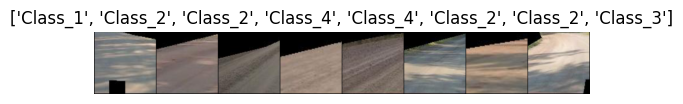

Prediction:


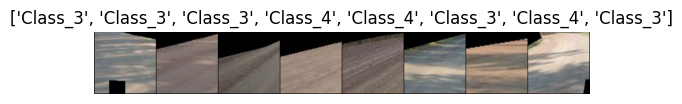

In [13]:
visualize_vis_model(V_vgg16) #test before training

In [14]:
def train_vis_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN_VIS])
    val_batches = len(dataloaders[VAL_VIS])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN_VIS]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes[TRAIN_VIS]
        avg_acc = acc_train / dataset_sizes[TRAIN_VIS]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL_VIS]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL_VIS]
        avg_acc_val = acc_val / dataset_sizes[VAL_VIS]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (visual train): {:.4f}".format(avg_loss))
        print("Avg acc (visual train): {:.4f}".format(avg_acc))
        print("Avg loss (visual val): {:.4f}".format(avg_loss_val))
        print("Avg acc (visual val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best visual baseline acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [15]:
V_vgg16 = train_vis_model(V_vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/2
----------
Training batch 0/46
Validation batch 0/14

<ipython-input-14-e29ee026ad13>:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Epoch 0 result: 
Avg loss (visual train): 0.1587
Avg acc (visual train): 0.4196
Avg loss (visual val): 0.1669
Avg acc (visual val): 0.4095
----------

Epoch 1/2
----------
Training batch 0/46
Validation batch 0/14
Epoch 1 result: 
Avg loss (visual train): 0.1416
Avg acc (visual train): 0.5259
Avg loss (visual val): 0.1661
Avg acc (visual val): 0.4000
----------


Training completed in 0m 42s
Best visual baseline acc: 0.4095


In [16]:
# Specify the path to save the model
vis_model_path = '/content/drive/MyDrive/Loose Gravel Condition/models/visual_baseline/VGG16_Gravel_Visual_dataset.pt'

# Save the model
torch.save(V_vgg16.state_dict(), vis_model_path)

In [17]:
eval_vis_model(V_vgg16, criterion)

Evaluating model
----------
Test batch 0/7

<ipython-input-8-e67e3ef766e7>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Evaluation completed in 0m 1s
Avg loss (test): 0.1756
Avg acc (test): 0.3333
----------


<ipython-input-7-7038849745e9>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


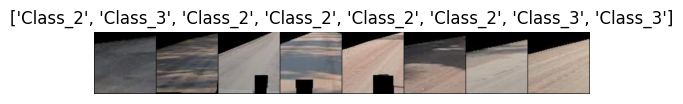

Prediction:


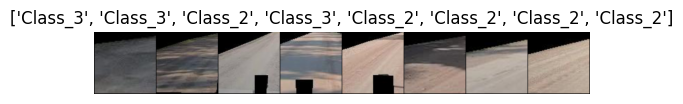

Ground truth:


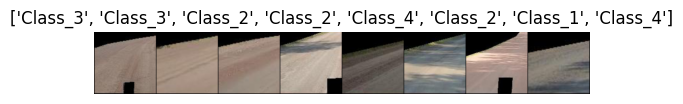

Prediction:


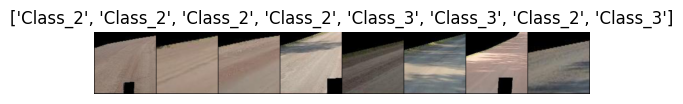

Ground truth:


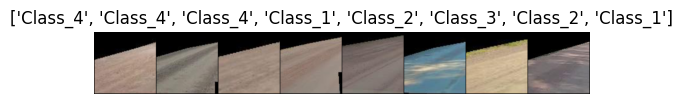

Prediction:


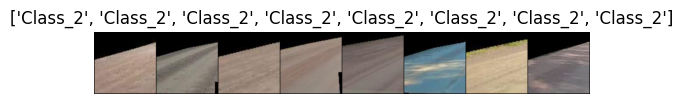

Ground truth:


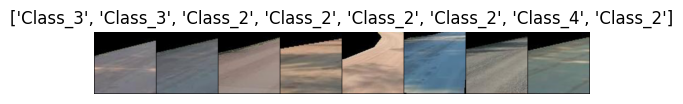

Prediction:


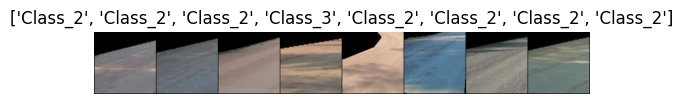

In [18]:
visualize_vis_model(V_vgg16, num_images=32)


# Audio Baseline

In [19]:
aud_data_dir = '/content/drive/MyDrive/Loose Gravel Condition/audio'
TRAIN_AUD = 'train'
VAL_AUD = 'valid'
TEST_AUD = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN_AUD: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL_AUD: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST_AUD: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

audio_datasets = {
    x: datasets.ImageFolder(
        os.path.join(aud_data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN_AUD, VAL_AUD, TEST_AUD]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        audio_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN_AUD, VAL_AUD, TEST_AUD]
}

dataset_sizes = {x: len(audio_datasets[x]) for x in [TRAIN_AUD, VAL_AUD, TEST_AUD]}

for x in [TRAIN_AUD, VAL_AUD, TEST_AUD]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
aud_class_names = audio_datasets[TRAIN_AUD].classes
print(audio_datasets[TRAIN_AUD].classes)

Loaded 369 images under train
Loaded 105 images under valid
Loaded 54 images under test
Classes: 
['Class_1', 'Class_2', 'Class_3', 'Class_4']


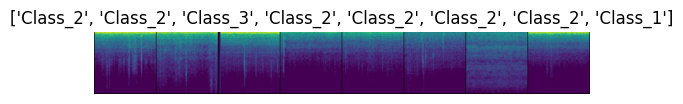

In [20]:
# Get a batch of training data
aud_inputs, aud_classes = next(iter(dataloaders[TRAIN_AUD]))
show_databatch(aud_inputs, aud_classes)

In [20]:
def visualize_aud_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST_AUD]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [21]:
def eval_aud_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST_AUD])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST_AUD]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
          inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST_AUD]
    avg_acc = acc_test / dataset_sizes[TEST_AUD]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [22]:
# Load the pretrained model from pytorch
A_vgg16 = models.vgg16_bn()
A_vgg16.load_state_dict(torch.load("/content/drive/MyDrive/Loose Gravel Condition/vgg16/vgg16_bn-6c64b313.pth"))
print(A_vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in A_vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = A_vgg16.classifier[6].in_features
features = list(A_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(aud_class_names))]) # Add our layer with 4 outputs
A_vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(A_vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [23]:
if use_gpu:
    A_vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(A_vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
print("Test before training")
eval_aud_model(A_vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/7

<ipython-input-21-ebb0d9bb6d1f>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Evaluation completed in 0m 7s
Avg loss (test): 0.1827
Avg acc (test): 0.1111
----------


<ipython-input-20-12e66ab6db27>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


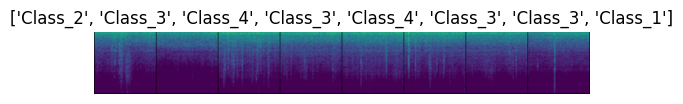

Prediction:


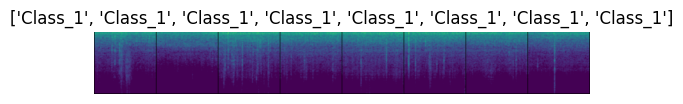

In [25]:
visualize_aud_model(A_vgg16) #test before training

In [26]:
def train_aud_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN_AUD])
    val_batches = len(dataloaders[VAL_AUD])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN_AUD]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes[TRAIN_AUD]
        avg_acc = acc_train / dataset_sizes[TRAIN_AUD]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL_AUD]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL_AUD]
        avg_acc_val = acc_val / dataset_sizes[VAL_AUD]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (audio train): {:.4f}".format(avg_loss))
        print("Avg acc (audio train): {:.4f}".format(avg_acc))
        print("Avg loss (audio val): {:.4f}".format(avg_loss_val))
        print("Avg acc (audio val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best audio baseline acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [27]:
A_vgg16 = train_aud_model(A_vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/2
----------
Training batch 0/47
Validation batch 0/14

<ipython-input-26-8efd950a64df>:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Epoch 0 result: 
Avg loss (audio train): 0.1588
Avg acc (audio train): 0.4038
Avg loss (audio val): 0.1601
Avg acc (audio val): 0.4476
----------

Epoch 1/2
----------
Training batch 0/47
Validation batch 0/14
Epoch 1 result: 
Avg loss (audio train): 0.1511
Avg acc (audio train): 0.4851
Avg loss (audio val): 0.1542
Avg acc (audio val): 0.5524
----------


Training completed in 0m 53s
Best audio baseline acc: 0.5524


In [28]:
# Specify the path to save the model
aud_model_path = '/content/drive/MyDrive/Loose Gravel Condition/models/audio_baseline/VGG16_Gravel_Audio_dataset.pt'

# Save the model
torch.save(A_vgg16.state_dict(), aud_model_path)

In [29]:
eval_aud_model(A_vgg16, criterion)

Evaluating model
----------
Test batch 0/7

<ipython-input-21-ebb0d9bb6d1f>:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)



Evaluation completed in 0m 1s
Avg loss (test): 0.1578
Avg acc (test): 0.4444
----------


<ipython-input-20-12e66ab6db27>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


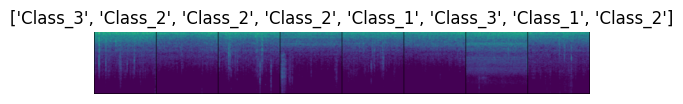

Prediction:


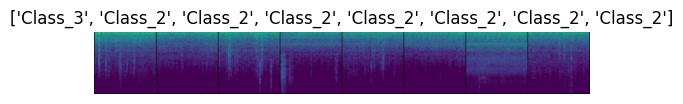

Ground truth:


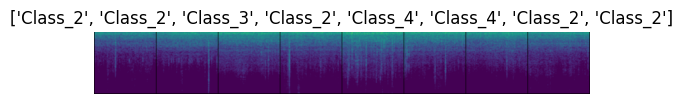

Prediction:


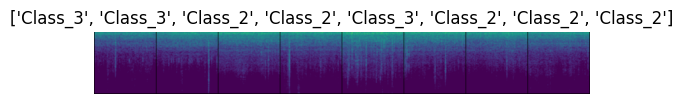

Ground truth:


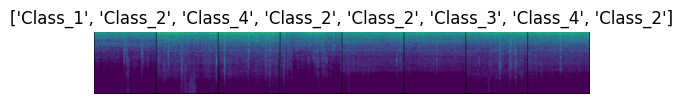

Prediction:


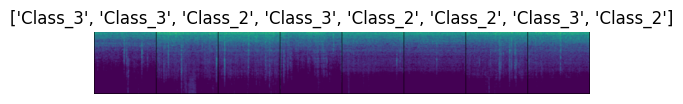

Ground truth:


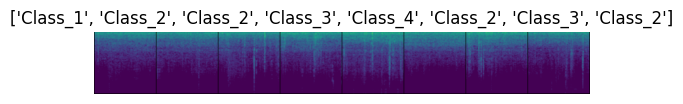

Prediction:


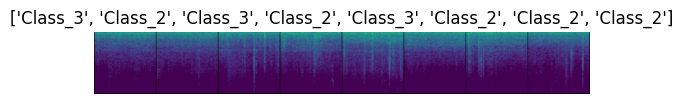

In [30]:
visualize_aud_model(A_vgg16, num_images=32)


# Fusion